**Name:** WANG Shixiang

>A picture is worth a thousand words. But did you know a picture can save a thousand lives? Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. You might expect pets with attractive photos to generate more interest and be adopted faster. But what makes a good picture? With the help of data science, you may be able to accurately determine a pet photo’s appeal and even suggest improvements to give these rescue animals a higher chance of loving homes.
>
>PetFinder.my is Malaysia’s leading animal welfare platform, featuring over 180,000 animals with 54,000 happily adopted. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.
>
>Currently, PetFinder.my uses a basic Cuteness Meter to rank pet photos. It analyzes picture composition and other factors compared to the performance of thousands of pet profiles. While this basic tool is helpful, it's still in an experimental stage and the algorithm could be improved.
>
>In this competition, you’ll analyze raw images and metadata to predict the “Pawpularity” of pet photos. You'll train and test your model on PetFinder.my's thousands of pet profiles. Winning versions will offer accurate recommendations that will improve animal welfare.
>
>If successful, your solution will be adapted into AI tools that will guide shelters and rescuers around the world to improve the appeal of their pet profiles, automatically enhancing photo quality and recommending composition improvements. As a result, stray dogs and cats can find their "furever" homes much faster. With a little assistance from the Kaggle community, many precious lives could be saved and more happy families created.

# YOUR METHODS HERE

##### Initialize Python

In [1]:
# import packages
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import matplotlib.mlab as mlab
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats
import zipfile
import cv2
import seaborn as sns; sns.set_theme()
from PIL import Image
from pandas import Series,DataFrame

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate,MaxPooling2D,InputLayer,AveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')
import tensorflow.keras.applications.resnet50 as resnet
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

/var/folders/3h/729_37h57cj7htnjk8qv4tkw0000gn/T/ipykernel_77308/1392842561.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("svg")


Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0
GPU is available


#####  Loading train data and test data

In [2]:
# Unzip the data file
# f = zipfile.ZipFile("petfinder-pawpularity-score.zip",'r') 
# for file in f.namelist():
#     f.extract(file,"petfinder-pawpularity-score/")
# f.close()

In [3]:
train_csv_path = 'petfinder-pawpularity-score/train.csv'
test_csv_path = 'petfinder-pawpularity-score/test.csv'
train_imgs_path = 'petfinder-pawpularity-score/train'
test_imgs_path = 'petfinder-pawpularity-score/test'
dataset_path = 'petfinder-pawpularity-score'
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

#####  Define util functions

In [4]:
def write_csv_kaggle_sub(name, Y):
    test_df = pd.read_csv(test_csv_path)
    test_df["Pawpularity"] = Y
    test_df = test_df[["Id", "Pawpularity"]]
    test_df.to_csv(name, index=False)

In [5]:
# function to evaluate root mean squared error (MSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

In [6]:
# function to show images
def showImgs(nrows, ncols, df):
    for i in range(nrows*ncols):
        img = mpimg.imread(train_imgs_path_dic.get(df.Id.values[i]))
        plt.subplot(nrows,ncols,i+1)
#         img = cv2.resize(img, (imgsize, imgsize))
        plt.axis("off")
        plt.tight_layout()
        plt.imshow(img)

In [7]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

#### Exploratory MetaData Analysis

- Explore features of metadata  
    - Get the feature columns  (We need to drop Id and Pawpularity since Id is useless to the model and Pawpularity is lable)
    - Show some simple statistics of the features.
    - Show the distribution of the features.

In [8]:
train_features=train_df.get(["Subject Focus","Eyes","Face","Near","Action","Accessory","Group","Collage","Human","Occlusion","Info","Blur"])
test=test_df.get(["Subject Focus","Eyes","Face","Near","Action","Accessory","Group","Collage","Human","Occlusion","Info","Blur"])
train_features.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


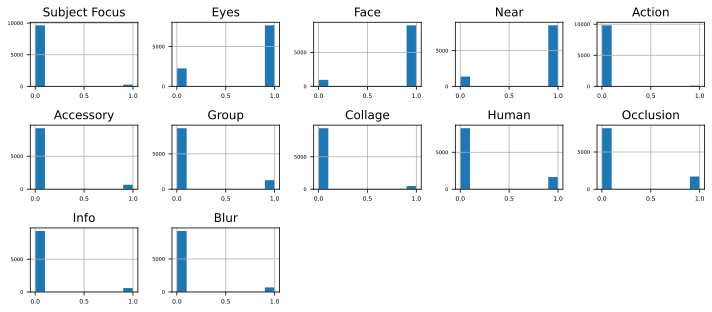

In [9]:
# show the features distributions
foo = train_features.hist(layout=(14,5), figsize=(10,20), xlabelsize=6, ylabelsize=5)
plt.tight_layout()

- Explore lable of metadata  
    - Examine the distribution of the labels(Pawpularity)
    - Calculate the statistical information of lablels

Number of unique values: 100
Mean of Pawpularity: 38.03904358353511
Median of Pawpularity: 33.0
Sigma of Pawpularity: 20.59199010577444
Min value of Pawpularity: 1
Max value of Pawpularity: 100


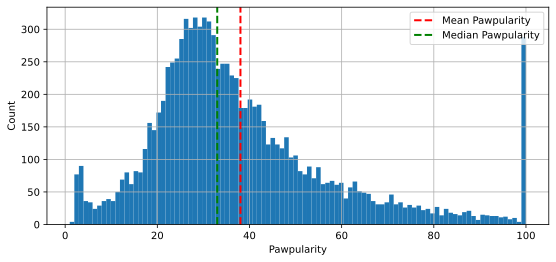

In [10]:
import numpy as np
Y = train_df["Pawpularity"]
Y.hist(bins=100, figsize=(9,4))
plt.axvline(Y.mean(), c='red', ls='--', lw=2, label='Mean Pawpularity')
plt.axvline(Y.median(),c='green',ls='--',lw=2, label='Median Pawpularity')
plt.legend()
plt.xlabel('Pawpularity')
plt.ylabel('Count')
print("Number of unique values:", len(train_df['Pawpularity'].unique()))
# lable size
# print(Y.shape)
print("Mean of Pawpularity:",Y.mean())
print("Median of Pawpularity:",Y.median())
print("Sigma of Pawpularity:",Y.std())
print("Min value of Pawpularity:",Y.min())
print("Max value of Pawpularity:",Y.max())

- Examine the correlation 
    - between features and features
    - between features and label

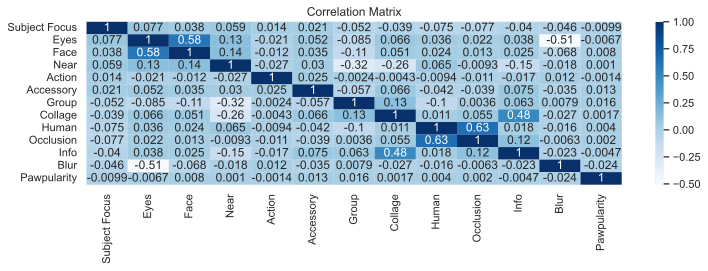

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,3)})
sns.heatmap(train_df.corr(), cmap="Blues",annot=True)
plt.title('Correlation Matrix')
plt.rc('font',size=1)
plt.show()

- Analysis
    - There are only twelve features in the train metadata.
    - Only Eyes, Face, Near these three features have more one value than zero.But actually I calculate the mean Pawpularity of the train data whose Eyes, Face, and Near equal to 0, the mean is 37.374046 that is similiar to the mean of all train data.
    - The Action value of 9813 pieces train data is 0, while only 99 pieces have 1, the mean Pawpularity of these 99 pieces is 37.757576 which is very close to the mean of all trainning data. So we could get that Action does not have many contribution to the Pawpularity. The Correlation Matrix also verifies this truth, Action has the lowest correlation value.
    - From the correlation matrix, we could get that Each individual feature has very little contribution to pawpularity.
    - There are total 12 features in the train metadata, each feature's value is zero or one, so there are at most 2^12=4096 different train data but here we have 9912 pieces train data, so there must be lots of data that have same value of the all twelve features but different Pawpularity, these data will make our model confused. 
    - Actually, there are only 272 pieces of train data have total different value of features, if we we drop the other 9640 pieces, the train data will be too few. But if we do not drop it, the same data but have different Pawpularity will misleading our model. So if we use these metadata to train our model,the outcome may be not good.

#### Model Training, Testing, and Prediction using metadata

- Split data into train and validation set

In [12]:
# randomly split data into 80% train and 20% validation set
trainX, valX, trainY, valY = \
  model_selection.train_test_split(train_features, Y, 
  train_size=0.90, test_size=0.10, random_state=4487)

print(trainX.shape)
print(valX.shape)

(8920, 12)
(992, 12)


##### Prediction with Linear Regression

- OLS

In [14]:
# using ordinary least squares
ols = linear_model.LinearRegression()
ols.fit(trainX, trainY)

print("ols MSE,RMAE =", eval_predict(valY, ols.predict(valX)))

ols MSE,RMAE = (20.73824764611121, 15.76785972406625)


- Ridge Regression

In [15]:
# using Ridge Regression
# alpha values to try
alphas = logspace(-3,3,10)
# train RR with cross-validation
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainX, trainY)

print("Ridge Regression RMSE,MAE =", eval_predict(valY, rr.predict(valX)))

Ridge Regression RMSE,MAE = (20.743712171549397, 15.756259950364006)


- LASSO

In [16]:
# fit with cross-validation
las = linear_model.LassoCV()
las.fit(trainX, trainY)

print("lasso Regression RMSE,MAE =", eval_predict(valY, las.predict(valX)))

lasso Regression RMSE,MAE = (20.75573688225275, 15.767690402140891)


##### Prediction with Non-Linear Regression

- Kernel Ridge Regression

In [17]:
# parameters for cross-validation
paramgrid = {'alpha': logspace(-2,2,5),
          'gamma': logspace(-2,2,5)}

# do cross-validation
krrcv = model_selection.GridSearchCV(
  kernel_ridge.KernelRidge(kernel='rbf'),  # estimator
  paramgrid,                              # parameters to try
  scoring='neg_mean_squared_error',       # score function
  cv=5,                                   # number of folds
  n_jobs=-1, verbose=True)
krrcv.fit(trainX, trainY)

print(krrcv.best_score_)
print(krrcv.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
-423.17703544278993
{'alpha': 10.0, 'gamma': 0.1}


In [18]:
print("Kernel Ridge Regression RMSE,MAE =", eval_predict(valY, krrcv.predict(valX)))

Kernel Ridge Regression RMSE,MAE = (20.717123104065067, 15.736461514585494)


- Support Vector Regression

In [19]:
# parameters for cross-validation
paramgrid = {'C':       logspace(-2,2,5),
             'gamma':   logspace(-2,2,5),
             'epsilon': logspace(-2,2,5)}

# do cross-validation 
svrcv = model_selection.GridSearchCV(
    svm.SVR(kernel='rbf'),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5, 
    n_jobs=-1, verbose=1)                # show progress
svrcv.fit(trainX, trainY)

print(svrcv.best_score_)
print(svrcv.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
-430.85835459826467
{'C': 10.0, 'epsilon': 10.0, 'gamma': 0.1}


In [20]:
print("Support Vector Regression RMSE,MAE =", eval_predict(valY, svrcv.predict(valX)))

Support Vector Regression RMSE,MAE = (20.817379745431104, 15.129932661840236)


- Random Forest Regression

In [21]:
# parameters for cross-validation
paramgrid = {'max_depth': array([1,2,3,4,5,6,7,8,9,10,11,12,13,14]),
            }

# do cross-validation
rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(n_estimators=1000, random_state=4487),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5,
    n_jobs=-1, verbose=True
)
rfcv.fit(trainX, trainY)

print(rfcv.best_score_)
print(rfcv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
-423.26150715885416
{'max_depth': 3}


In [22]:
print("Random Forest Regression RMSE,MAE =", eval_predict(valY, rfcv.predict(valX)))

Random Forest Regression RMSE,MAE = (20.716464671286573, 15.739780845467504)


- Here I tried linear and Non-linear regression and did cross-validation, respectively. The best model is Random Forest Regression the validation MRES is 20.716464671286573, which is not so good as we analyzed before.

##### Prediction with Using PCA

- Let us try  to use PCA to reduce the input dimension on the metadata and using the best model above (Random Forest Regression) to make predict.
    - As the number of features is only 12, whcih is not too many compared to the unique of pawpularity, so we would better only reduce few dimensions.

In [13]:
# run PCA
pca = decomposition.PCA(n_components=10)
trainW   = pca.fit_transform(trainX)  # returns the coefficients
valW   = pca.transform(valX)
testW   = pca.transform(test)
v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean
(trainW.shape, valW.shape)

((8920, 10), (992, 10))

In [14]:
# parameters for cross-validation
paramgrid = {'max_depth': array([1,2,3,4,5,6,7,8,9,10,11,12,13,14]),
            }

# do cross-validation
PCA_rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(n_estimators=1000, random_state=4487),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5,
    n_jobs=-1, verbose=True
)
PCA_rfcv.fit(trainW, trainY)

print(PCA_rfcv.best_score_)
print(PCA_rfcv.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
-423.2653393710858
{'max_depth': 2}


In [15]:
print("PCA RMSE,MAE =", eval_predict(valY, PCA_rfcv.predict(valW)))

PCA RMSE,MAE = (20.718815193707346, 15.747754263136668)


##### Prediction with Cluster

- So far, we did not try cluster. Here, there are one hundred different values of pawpularity, so we make one hundred clusters

In [16]:
km = cluster.KMeans(n_clusters=100, random_state=4487)
trainXk = km.fit_predict(trainX)
valXk = km.predict(valX)
testk = km.predict(test)

In [17]:
print("Kmeans Cluster RMSE,MAE =", eval_predict(valY, valXk))

Kmeans Cluster RMSE,MAE = (37.62706965693371, 31.336693548387096)


- Because there are too many training data with different pawpularity but the same feature value, the outcome of kmeans cluster is not good

### Exploratory RawImage Analysis

Mapping the id of training images and test images corresponding to the file path

In [23]:
# dictionary. key:name of the image file, value: the path of the image file
train_imgs_path_dic={}
train_imgs_path_list= os.listdir(train_imgs_path)
for i in range(len(train_imgs_path_list)):
    train_imgs_path_dic[os.path.splitext(train_imgs_path_list[i])[0]]=train_imgs_path+"/"+train_imgs_path_list[i]
# sample value of the dictionary
print(train_imgs_path_dic.get(os.path.splitext(train_imgs_path_list[0])[0]))
# size of the dictionary equals to total number of images
print(len(train_imgs_path_dic))

petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg
9912


In [24]:
# dictionary. key:name of the image file, value: the path of the image file
test_imgs_path_dic={}
test_imgs_path_list= os.listdir(test_imgs_path)
for i in range(len(test_imgs_path_list)):
    test_imgs_path_dic[os.path.splitext(test_imgs_path_list[i])[0]]=test_imgs_path+"/"+test_imgs_path_list[i]
# sample value of the dictionary
print(test_imgs_path_dic.get(os.path.splitext(test_imgs_path_list[0])[0]))
# size of the dictionary equals to total number of images
print(len(test_imgs_path_dic))

petfinder-pawpularity-score/test/4128bae22183829d2b5fea10effdb0c3.jpg
8


- Show the first twelve images with 100 Pawpularity

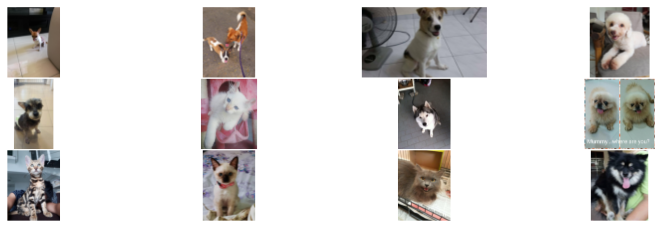

In [26]:
showImgs(3,4,train_df[train_df.Pawpularity==100])

- Show  images with only 1 Pawpularity

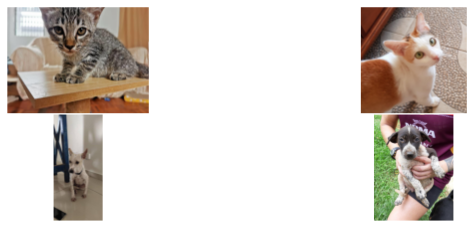

In [27]:
showImgs(2,2,train_df[train_df.Pawpularity==1])

We could firstly find that different raw images have different size, so look at the relationship between the size of the image and Pawpularity

In [28]:
# a list of width of all images
Img_width=[]
# a list of height of all images
Img_height=[]
for i in range(len(train_imgs_path_dic)):
    img = Image.open(train_imgs_path_dic.get(os.path.splitext(train_imgs_path_list[i])[0]))
    Img_width.append(img.size[0])
    Img_height.append(img.size[1])
Image_size_data = {'Pawpularity':Y,
       'ImageWidth':Img_width,
       'ImageHeight':Img_height}
# Construct a dataframe
Image_size_data_df = DataFrame(Image_size_data)

Examine the correlation between image size and Pawpularity

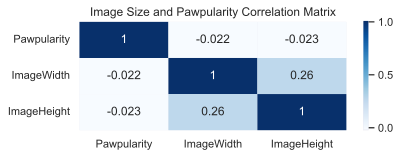

In [29]:
sns.set(rc={'figure.figsize':(6,2)})
sns.heatmap(Image_size_data_df.corr(), cmap="Blues",annot=True)
plt.title('Image Size and Pawpularity Correlation Matrix')
plt.rc('font',size=1)
plt.show()

As we can get from the matrix, the width and height of the image has almost nothing to do with the pawpularity. This information is very important since when we would like to extract features from raw images, we usually hope the size of these photos to be consistent.

#### Model Training, Testing, and Prediction using metadata

- Load taining and test images and set all images size to (128,128,3) (Here we choose this speciall width and height because my computer and the kaggle service cannnot do such a complicated compution.)

In [30]:
train_df = pd.read_csv(train_csv_path)
train_df['path'] = train_df['Id'].map(lambda x:str.format(dataset_path)+'/train/'+x+'.jpg')
print(train_df['path'][0])
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle data

petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg


In [31]:
test_df = pd.read_csv(test_csv_path)
test_df['path'] = test_df['Id'].map(lambda x:str.format(dataset_path)+'/test/'+x+'.jpg')
print(test_df['path'][0])
test_df = test_df.drop(columns=['Id'])
test_df = test_df.sample(frac=1).reset_index(drop=True) #shuffle data

petfinder-pawpularity-score/test/4128bae22183829d2b5fea10effdb0c3.jpg


- The same reason as choose images size (128,128,3), here I only used 6000 raw pictures to train

In [32]:
data_num = 6000
img_size =(128,128)
tunnel_size = (128,128,3)
trainimg = []
for i in range(data_num):
    image_string = tf.io.read_file(train_df['path'][i])
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize(image_decoded, img_size)
    trainimg.append(image_resized)

In [33]:
testimg = []
for i in range(len(test_df)):
    image_string = tf.io.read_file(test_df['path'][i])
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize(image_decoded, img_size)
    testimg.append(image_resized)

In [34]:
trainimg = array(trainimg)
print(trainimg.shape)
testimg = array(testimg)
print(testimg.shape)
Y = train_df["Pawpularity"]
Y = Y[0:data_num]
print(Y.shape)

(6000, 128, 128, 3)
(8, 128, 128, 3)
(6000,)


- Nomorlize the data to 0-1 which neural network prefers.

In [35]:
# map the data to [0,1]
train_X=trainimg/255.0
test_X = testimg/255.0
Itrain=train_X.reshape(train_X.shape[0],train_X.shape[1],train_X.shape[1]*3)
Itest=test_X.reshape(test_X.shape[0],test_X.shape[1],test_X.shape[1]*3)

- Multi-layer perceptron

- Randomly split data into 80% train and 20% validation set

In [36]:
train_x, val_x, train_Y, val_Y = \
  model_selection.train_test_split(Itrain, Y, 
  train_size=0.8, test_size=0.2, random_state=4487)
((train_x.shape), (val_x.shape), (train_Y.shape), (val_Y.shape))

((4800, 128, 384), (1200, 128, 384), (4800,), (1200,))

In [37]:
# initialize random seed
K.clear_session()
random.seed(4487); tf.random.set_seed(4487)

# build the network
nn = Sequential()
nn.add(Flatten(input_shape=(train_x.shape[1], train_x.shape[2])))
# 5 hidden layer
nn.add(Dense(units=1024, activation='relu'))
nn.add(Dense(units=512, activation='relu'))
nn.add(Dense(units=256, activation='relu'))
nn.add(Dense(units=64, activation='relu'))
nn.add(Dense(units=64, activation='relu'))
nn.add(Dense(units=1, activation='relu'))

# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)

callbacks_list = [earlystop]

# compile and fit the network
nn.compile( loss = keras.losses.MeanSquaredError(), # use mean squared error
            optimizer=keras.optimizers.Adam(),
           # optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
            metrics = ['mean_squared_error'] 
          )

history_nn=nn.fit(train_x, train_Y, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x, val_Y),  # specify the validation set
                 verbose=1)

Epoch 1/100
48/48 [==============================] - 18s 360ms/step - loss: 700.7166 - mean_squared_error: 700.7166 - val_loss: 501.3509 - val_mean_squared_error: 501.3509
Epoch 2/100
48/48 [==============================] - 16s 334ms/step - loss: 505.7188 - mean_squared_error: 505.7188 - val_loss: 487.9014 - val_mean_squared_error: 487.9014
Epoch 3/100
48/48 [==============================] - 16s 337ms/step - loss: 512.3016 - mean_squared_error: 512.3017 - val_loss: 531.2977 - val_mean_squared_error: 531.2977
Epoch 4/100
48/48 [==============================] - 16s 331ms/step - loss: 480.1839 - mean_squared_error: 480.1839 - val_loss: 473.3593 - val_mean_squared_error: 473.3593
Epoch 5/100
48/48 [==============================] - 16s 329ms/step - loss: 481.0627 - mean_squared_error: 481.0627 - val_loss: 482.6629 - val_mean_squared_error: 482.6629
Epoch 6/100
48/48 [==============================] - 16s 332ms/step - loss: 472.5297 - mean_squared_error: 472.5297 - val_loss: 463.1359 - v

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              50332672  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6

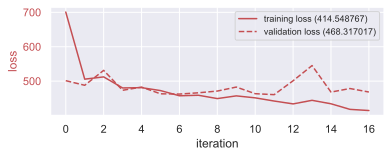

In [38]:
 plot_history(history_nn)
 nn.summary()

In [39]:
mlp_predict=nn.predict(val_x)
print("MLP RMSE,MAE =", eval_predict(val_Y, mlp_predict))

MLP RMSE,MAE = (21.64063389579775, 15.9560591562589)


- We could get that deep learning model is not good from above, so we tried to use transfer learning

In [40]:
trainXim, valXim, trainYim, valYim = \
  model_selection.train_test_split(train_X, Y, 
  train_size=0.8, test_size=0.2, random_state=4487)
((trainXim.shape), (valXim.shape), (trainYim.shape), (valYim.shape))

((4800, 128, 128, 3), (1200, 128, 128, 3), (4800,), (1200,))

- Define a function to return different available models. Here I tried six.
    - ResNet152V2
    - ResNet50
    - InceptionResNetV2
    - DenseNet201
    - EfficientNetB7
    - Xception

In [41]:
# try different available models to get pre-trained weights.
# reference https://keras.io/api/applications/
def transferModel(model_name):
    print('model transfer start--'+model_name)
    if model_name == "ResNet152V2":
        model = tf.keras.applications.ResNet152V2( include_top=False, weights='imagenet',input_shape = tunnel_size)
    if model_name == "ResNet50":
        model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape = tunnel_size )
    if model_name == "InceptionResNetV2":
        model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',input_shape = tunnel_size)
    if model_name == "DenseNet201":
        model = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet',input_shape = tunnel_size)
    if model_name == "EfficientNetB7":
        model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet',input_shape = tunnel_size)
    if model_name == "Xception":
        model = tf.keras.applications.Xception(include_top=False, weights='imagenet',input_shape = tunnel_size)
    model.trainable = False
    print('model transfer end--'+model_name)
    return model

- Define a function to preprocess the input of different Keras Application

In [42]:
# each Keras Application expects a specific kind of input preprocessing, so we should apply preprocess_input 
# to convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
# here I reference https://keras.io/api/applications/
def preprocessInput(model_name):
    print('preprocessInput start--'+ model_name)
    if model_name == "ResNet152V2":
        preprocess_Input=tf.keras.applications.resnet_v2.preprocess_input
    if model_name == "ResNet50":
        preprocess_Input=tf.keras.applications.resnet50.preprocess_input
    if model_name == "InceptionResNetV2":
        preprocess_Input=tf.keras.applications.inception_resnet_v2.preprocess_input
    if model_name == "DenseNet201":
        preprocess_Input=tf.keras.applications.densenet.preprocess_input
    if model_name == "EfficientNetB7":
        preprocess_Input=tf.keras.applications.efficientnet.preprocess_input
    if model_name == "Xception":
        preprocess_Input=tf.keras.applications.xception.preprocess_input 
    print('preprocessInput end--'+model_name)
    return preprocess_Input

- Define a function to give different noise on the raw picture. Here I tried 4.
    - Add No Noise
    - Add Guass Noise
    - Add Corrupt Noise
    - Add Scale Shift Noise

In [43]:
def add_no_noise(X):
    return X 

def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0) 

- Define a function to add noise to the raw data

In [44]:
def dataAugmentation(aug_name):
    print('dataAugmentation start--'+aug_name)
    if aug_name == "add_gauss_noise":
        ret = add_gauss_noise
    if aug_name == "add_corrupt_noise":
        ret = add_corrupt_noise
    if aug_name == "add_scale_shift":
        ret = add_scale_shift
    if aug_name == "add_no_noise":
        ret = add_no_noise
    print('dataAugmentation end--'+aug_name)
    return ret

- Define a function to preprocess train and validation data using above functions

In [45]:
def data_process(trans_model_name, agu_name, trainXim, valXim):
#   preprocess the input of different Keras Application
    trainXim = preprocessInput(trans_model_name)(trainXim)
    valXim = preprocessInput(trans_model_name)(valXim)
#   add augmentation
    train_x = dataAugmentation(agu_name)(trainXim)
    val_x = dataAugmentation(agu_name)(valXim)
    return train_x,val_x

- mode_1: tried to do feature extraction from InceptionResNetV2

In [46]:
# initialize random seed
K.clear_session()
random.seed(999); tf.random.set_seed(999)

# build model 1
model_1 = Sequential()
model_1.add(transferModel('InceptionResNetV2'))
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(units=256, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dense(units=128, activation='relu'))
model_1.add(Dense(units=64))
# model_1.add(Dropout(0.2))
model_1.add(Dense(units=1,activation=tf.keras.layers.ReLU(max_value = 100)))

model_1.summary()

model transfer start--InceptionResNetV2
model transfer end--InceptionResNetV2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
batch_normalization_203 (Bat (None, 2, 2, 1536)        6144      
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
batch_normalization_204 (Bat (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
____________________________________________

In [47]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
              monitor='val_loss',       
              min_delta=1, patience=3, 
              verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
model_1.compile( loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(),
             metrics = ['mean_squared_error'] 
          )
train_x,val_x = data_process('InceptionResNetV2', 'add_gauss_noise',trainXim, valXim)
history_model_1 = model_1.fit(train_x, trainYim, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x,valYim),  # specify the validation set
                 verbose=1)

preprocessInput start--InceptionResNetV2
preprocessInput end--InceptionResNetV2
preprocessInput start--InceptionResNetV2
preprocessInput end--InceptionResNetV2
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
Epoch 1/100
48/48 [==============================] - 222s 4s/step - loss: 705.8855 - mean_squared_error: 705.8855 - val_loss: 973.2528 - val_mean_squared_error: 973.2528
Epoch 2/100
48/48 [==============================] - 226s 5s/step - loss: 412.8303 - mean_squared_error: 412.8303 - val_loss: 730.6570 - val_mean_squared_error: 730.6570
Epoch 3/100
48/48 [==============================] - 214s 4s/step - loss: 376.1781 - mean_squared_error: 376.1781 - val_loss: 660.9352 - val_mean_squared_error: 660.9352
Epoch 4/100
48/48 [==============================] - 203s 4s/step - loss: 321.5601 - mean_squared_error: 321.5601 - val_loss: 583.3026 - val_mean_squared_error: 583.3026
Epoc

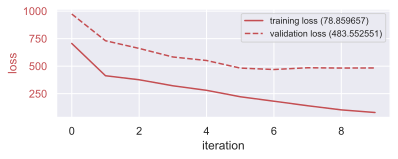

In [48]:
plot_history(history_model_1)

In [49]:
model_1_predict=model_1.predict(valXim)
print("model_1 RMSE,MAE =", eval_predict(valYim, model_1_predict))

model_1 RMSE,MAE = (20.965820018274336, 15.996552220980327)


- mode_2: tried to do feature extraction from DenseNet201

In [50]:
# initialize random seed
K.clear_session()
random.seed(999); tf.random.set_seed(999)

# build mode2
model_2 = Sequential()
model_2.add(transferModel('DenseNet201'))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(units=256, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(units=128, activation='relu'))
model_2.add(Dense(units=64, activation='relu'))
# model_2.add(Dropout(0.2))
model_2.add(Dense(units=1, activation=tf.keras.layers.ReLU(max_value = 100)))

model_2.summary()

model transfer start--DenseNet201
model transfer end--DenseNet201
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 1920)        7680      
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7864576   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
________________________________________________________

In [51]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
              monitor='val_loss',       
              min_delta=1, patience=3, 
              verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
model_2.compile( loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(),
             metrics = ['mean_squared_error'] 
          )
train_x,val_x = data_process('DenseNet201', 'add_gauss_noise',trainXim, valXim)
history_model_2 = model_2.fit(train_x, trainYim, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x,valYim),  # specify the validation set
                 verbose=1)

preprocessInput start--DenseNet201
preprocessInput end--DenseNet201
preprocessInput start--DenseNet201
preprocessInput end--DenseNet201
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
Epoch 1/100
48/48 [==============================] - 297s 6s/step - loss: 1015.0632 - mean_squared_error: 1015.0632 - val_loss: 674.2979 - val_mean_squared_error: 674.2979
Epoch 2/100
48/48 [==============================] - 283s 6s/step - loss: 396.3840 - mean_squared_error: 396.3840 - val_loss: 475.7418 - val_mean_squared_error: 475.7418
Epoch 3/100
48/48 [==============================] - 283s 6s/step - loss: 272.6093 - mean_squared_error: 272.6093 - val_loss: 572.1353 - val_mean_squared_error: 572.1352
Epoch 4/100
48/48 [==============================] - 293s 6s/step - loss: 179.1754 - mean_squared_error: 179.1754 - val_loss: 731.3897 - val_mean_squared_error: 731.3897
Epoch 5/100
48/48 [=======

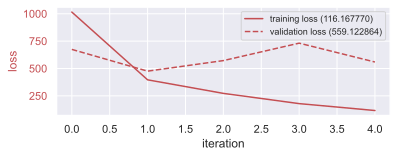

In [52]:
plot_history(history_model_2)

In [53]:
model_2_predict=model_2.predict(valXim)
print("model_2 RMSE,MAE =", eval_predict(valYim, model_2_predict))

model_2 RMSE,MAE = (21.230656647422844, 17.058412809371948)


- mode_3: tried to do feature extraction from ResNet152V2

In [54]:
# initialize random seed
K.clear_session()
random.seed(999); tf.random.set_seed(999)

# build mode3
model_3 = Sequential()
model_3.add(transferModel('ResNet152V2'))
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(units=256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dense(units=128, activation='relu'))
model_3.add(Dense(units=64, activation='relu'))
# model_3.add(Dropout(0.2))
model_3.add(Dense(units=1, activation=tf.keras.layers.ReLU(max_value = 100)))

model_3.summary()

model transfer start--ResNet152V2
model transfer end--ResNet152V2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
________________________________________________________

In [55]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
              monitor='val_loss',       
              min_delta=1, patience=3, 
              verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
model_3.compile( loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(),
             metrics = ['mean_squared_error'] 
          )
train_x,val_x = data_process('ResNet152V2', 'add_gauss_noise',trainXim, valXim)
history_model_3 = model_3.fit(train_x, trainYim, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x,valYim),  # specify the validation set
                 verbose=1)

preprocessInput start--ResNet152V2
preprocessInput end--ResNet152V2
preprocessInput start--ResNet152V2
preprocessInput end--ResNet152V2
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
Epoch 1/100
48/48 [==============================] - 484s 10s/step - loss: 975.2369 - mean_squared_error: 975.2369 - val_loss: 456.5110 - val_mean_squared_error: 456.5110
Epoch 2/100
48/48 [==============================] - 489s 10s/step - loss: 398.8136 - mean_squared_error: 398.8137 - val_loss: 449.5734 - val_mean_squared_error: 449.5733
Epoch 3/100
48/48 [==============================] - 489s 10s/step - loss: 296.3444 - mean_squared_error: 296.3444 - val_loss: 467.5207 - val_mean_squared_error: 467.5207
Epoch 4/100
48/48 [==============================] - 505s 11s/step - loss: 214.6590 - mean_squared_error: 214.6590 - val_loss: 475.9548 - val_mean_squared_error: 475.9548
Epoch 5/100
48/48 [=====

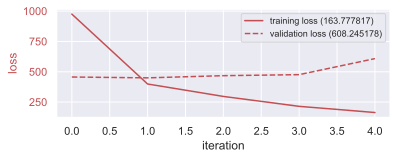

In [56]:
plot_history(history_model_3)

In [57]:
model_3_predict=model_3.predict(valXim)
print("model_3 RMSE,MAE =", eval_predict(valYim, model_3_predict))

model_3 RMSE,MAE = (32.38418958619872, 29.42764493306478)


- mode_4: tried to do feature extraction from ResNet50

In [58]:
# initialize random seed
K.clear_session()
random.seed(999); tf.random.set_seed(999)

# build mode4
model_4 = Sequential()
model_4.add(transferModel('ResNet50'))
model_4.add(BatchNormalization())
model_4.add(Flatten())
model_4.add(Dense(units=256, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dense(units=128, activation='relu'))
model_4.add(Dense(units=64, activation='relu'))
# model_4.add(Dropout(0.2))
model_4.add(Dense(units=1, activation=tf.keras.layers.ReLU(max_value = 100)))

model_4.summary()

model transfer start--ResNet50
model transfer end--ResNet50
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
______________________________________________________________

In [59]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
              monitor='val_loss',       
              min_delta=1, patience=2, 
              verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
model_4.compile( loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(),
             metrics = ['mean_squared_error'] 
          )
train_x,val_x = data_process('ResNet50', 'add_corrupt_noise',trainXim, valXim)
history_model_4 = model_4.fit(train_x, trainYim, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x,valYim),  # specify the validation set
                 verbose=1)

preprocessInput start--ResNet50
preprocessInput end--ResNet50
preprocessInput start--ResNet50
preprocessInput end--ResNet50
dataAugmentation start--add_corrupt_noise
dataAugmentation end--add_corrupt_noise
dataAugmentation start--add_corrupt_noise
dataAugmentation end--add_corrupt_noise
Epoch 1/100
48/48 [==============================] - 217s 4s/step - loss: 817.5500 - mean_squared_error: 817.5500 - val_loss: 513.3467 - val_mean_squared_error: 513.3467
Epoch 2/100
48/48 [==============================] - 214s 4s/step - loss: 341.5665 - mean_squared_error: 341.5665 - val_loss: 1014.0956 - val_mean_squared_error: 1014.0956
Epoch 3/100
48/48 [==============================] - 213s 4s/step - loss: 182.5324 - mean_squared_error: 182.5324 - val_loss: 602.5961 - val_mean_squared_error: 602.5961
Epoch 00003: early stopping


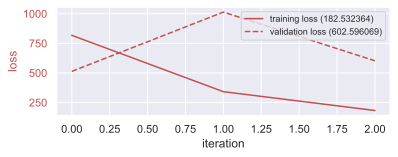

In [60]:
plot_history(history_model_4)

In [61]:
model_4_predict=model_4.predict(valXim)
print("model_4 RMSE,MAE =", eval_predict(valYim, model_4_predict))

model_4 RMSE,MAE = (31.414984160993658, 28.457210210164387)


- mode_5: tried to do feature extraction from EfficientNetB7

In [62]:
# initialize random seed
K.clear_session()
random.seed(999); tf.random.set_seed(999)

# build mode5
model_5 = Sequential()
model_5.add(transferModel('EfficientNetB7'))
model_5.add(BatchNormalization())
model_5.add(Flatten())
model_5.add(Dense(units=256, activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dense(units=128, activation='relu'))
model_5.add(Dense(units=64, activation='relu'))
# model_5.add(Dropout(0.2))
model_5.add(Dense(units=1, activation=tf.keras.layers.ReLU(max_value = 100)))

model_5.summary()

model transfer start--EfficientNetB7
model transfer end--EfficientNetB7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 4, 4, 2560)        64097687  
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 2560)        10240     
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               10486016  
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
__________________________________________________

In [63]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
              monitor='val_loss',       
              min_delta=1, patience=3, 
              verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
model_5.compile( loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(),
             metrics = ['mean_squared_error'] 
          )
train_x,val_x = data_process('EfficientNetB7', 'add_gauss_noise',trainXim, valXim)
history_model_5 = model_5.fit(train_x, trainYim, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x,valYim),  # specify the validation set
                 verbose=1)

preprocessInput start--EfficientNetB7
preprocessInput end--EfficientNetB7
preprocessInput start--EfficientNetB7
preprocessInput end--EfficientNetB7
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
Epoch 1/100
48/48 [==============================] - 657s 13s/step - loss: 1162.4086 - mean_squared_error: 1162.4087 - val_loss: 2624.0459 - val_mean_squared_error: 2624.0459
Epoch 2/100
48/48 [==============================] - 663s 14s/step - loss: 465.5693 - mean_squared_error: 465.5693 - val_loss: 4266.1675 - val_mean_squared_error: 4266.1675
Epoch 3/100
48/48 [==============================] - 657s 14s/step - loss: 443.2154 - mean_squared_error: 443.2154 - val_loss: 885.1823 - val_mean_squared_error: 885.1823
Epoch 4/100
48/48 [==============================] - 662s 14s/step - loss: 436.7862 - mean_squared_error: 436.7862 - val_loss: 440.2504 - val_mean_squared_error: 440.2504
Epoch 

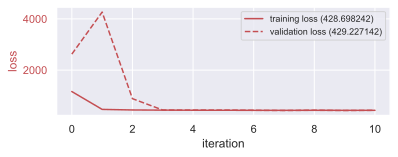

In [64]:
plot_history(history_model_5)

In [65]:
model_5_predict=model_5.predict(valXim)
print("model_5 RMSE,MAE =", eval_predict(valYim, model_5_predict))

model_5 RMSE,MAE = (20.718224338984903, 16.092647444407145)


- mode_6: tried to do feature extraction from Xception

In [66]:
# initialize random seed
K.clear_session()
random.seed(999); tf.random.set_seed(999)

# build mode2
model_6 = Sequential()
model_6.add(transferModel('Xception'))
model_6.add(BatchNormalization())
model_6.add(Flatten())
model_6.add(Dense(units=256, activation='relu'))
model_6.add(BatchNormalization())
model_6.add(Dense(units=128, activation='relu'))
model_6.add(Dense(units=64, activation='relu'))
# model_6.add(Dropout(0.2))
model_6.add(Dense(units=1, activation=tf.keras.layers.ReLU(max_value = 100)))

model_6.summary()

model transfer start--Xception
83697664/83683744 [==============================] - 7s 0us/step
model transfer end--Xception
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896   

In [67]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
              monitor='val_loss',       
              min_delta=1, patience=3, 
              verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
model_6.compile( loss = keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(),
             metrics = ['mean_squared_error'] 
          )
train_x,val_x = data_process('Xception', 'add_gauss_noise',trainXim, valXim)
history_model_6 = model_6.fit(train_x, trainYim, epochs=100, batch_size=100, 
                 callbacks=callbacks_list, 
                 validation_data=(val_x,valYim),  # specify the validation set
                 verbose=1)

preprocessInput start--Xception
preprocessInput end--Xception
preprocessInput start--Xception
preprocessInput end--Xception
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
dataAugmentation start--add_gauss_noise
dataAugmentation end--add_gauss_noise
Epoch 1/100
48/48 [==============================] - 286s 6s/step - loss: 1020.5333 - mean_squared_error: 1020.5332 - val_loss: 590.7047 - val_mean_squared_error: 590.7048
Epoch 2/100
48/48 [==============================] - 285s 6s/step - loss: 456.7571 - mean_squared_error: 456.7571 - val_loss: 957.4197 - val_mean_squared_error: 957.4197
Epoch 3/100
48/48 [==============================] - 247s 5s/step - loss: 422.9342 - mean_squared_error: 422.9342 - val_loss: 778.2110 - val_mean_squared_error: 778.2110
Epoch 4/100
48/48 [==============================] - 239s 5s/step - loss: 418.3411 - mean_squared_error: 418.3411 - val_loss: 654.0059 - val_mean_squared_error: 654.0059
Epoch 00004: early stopping


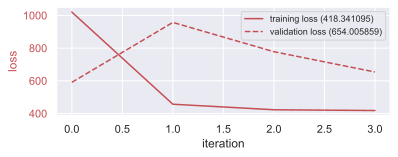

In [68]:
plot_history(history_model_6)

In [69]:
model_6_predict=model_6.predict(valXim)
print("model_6 RMSE,MAE =", eval_predict(valYim, model_6_predict))

model_6 RMSE,MAE = (27.282674789492592, 24.244772679011028)


### Generate final result

- As the errors of model_5 and  model_1, are the most minor and similar, we could ensemble the results. As the error of model_5 more was a little better than model_1, we gived model_5 a little more weight.

In [76]:
val_final_predict=model_1_predict*0.4+model_5_predict*0.6
print("final RMSE,MAE =", eval_predict(valYim, val_final_predict))

final RMSE,MAE = (20.669306288846442, 15.905551042556763)
